# 3DVar with Lorenz’63
## Pavitra Chandarana, Jan Stüwe

In this notebook, we apply three‐dimensional variational data assimilation to the chaotic Lorenz’63 model using synthetic noisy observations. We enhance the classical 3DVar analysis with a neural-network-based correction of the analysis increments and assess performance via RMSE and phase‐space diagnostics under different observational settings. Our results demonstrate the promise of hybrid variational–machine learning methods for improving state estimation in low‐dimensional chaotic systems.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import warnings
from typing import Callable, Dict

import plotly.graph_objects as go
import torch
from torch import nn

SEED = 42   # Setting a random seed for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)

warnings. filterwarnings("ignore", category=Warning)                

The Lorenz ’63 system is a classic example of a low-dimensional chaotic dynamical system, governed by the equations:


\begin{aligned}
\dot{x} &= \sigma\,(y - x),\\
\dot{y} &= x\,(\rho - z) - y,\\
\dot{z} &= x\,y - \beta\,z,
\end{aligned}


where the parameters are set to $\sigma = 10, \rho = 28, \beta = \frac{8}{3}.
$

We will now:

1. Integrate the Lorenz equations from $t=0$ to $t=T$ using SciPy’s adaptive RK45 solver with a fixed maximum step size $\Delta t$.
2. Visualize the resulting 3D trajectory.

**Integration settings**:

- Time span: $0 \le t \le T$, with $T = 200$  
- Time step for output: $\Delta t = 0.01$
- Number of steps: $n_{\text{steps}} = T / \Delta t$  
- Initial condition: $\mathbf{x}_0 = [1.0,\,1.0,\,1.0]$

In [2]:
σ = 10.0  
ρ = 28.0    
β = 8.0 / 3.0
dt = 0.01  

def lorenz63(x):
    x1, x2, x3 = x
    return np.array([
        σ * (x2 - x1),         
        x1 * (ρ - x3) - x2,   
        x1 * x2 - β * x3       
    ])

def rk4_step(x, f, h):
    k1 = f(x)                    # Slope at beginning of interval
    k2 = f(x + 0.5 * h * k1)     # Slope at midpoint using k1
    k3 = f(x + 0.5 * h * k2)     # Slope at midpoint using k2
    k4 = f(x + h * k3)           # Slope at end using k3
                                 # Weighted average of slopes: 1/6(k1 + 2k2 + 2k3 + k4)
    return x + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def integrate(x0, n_steps, h=dt):
    xs = np.empty((n_steps + 1, 3))  # Pre-allocate trajectory array
    xs[0] = x0                       # Store initial condition
    x = x0.copy()                    # Working copy to avoid modifying x0
    
    # Integrate forward using RK4
    for i in range(1, n_steps + 1):
        x = rk4_step(x, lorenz63, h)
        xs[i] = x                    # Store state at each time step
    return xs

def batch_integrate(x0_batch, n_steps, h=dt):
    return np.stack([integrate(x0, n_steps, h) for x0 in x0_batch])

The next step is to conduct a "nature run". We again integrate from $0 \leq T \leq 200$ with the given parameters.

Furthermore, we add a so called "stride" to save every second oberservation. In other words, we make observation with $\Delta t_{ \text{obs}} = 0.02$ and add some $\varepsilon \sim \mathcal{N}(0, 1)$.

Observe that our model state space and observation space have the same dimension, so we use 
$$ H:= \begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}.$$

In [3]:
T = 200.0   # Simulating for T = 200 (instructed in problem setting)
n_truth = int(T / dt)    
x0_truth = np.array([1.0, 1.0, 1.0])    # True X observation
org_time = np.linspace(0, 200, 20001)

truth = integrate(x0_truth, n_truth) 

stride = 2
obs_times_idx = np.arange(0, truth.shape[0], stride)
obs_times = obs_times_idx * dt

obs_noise_std = 1
H = np.eye(3)      # LINEAR OPERATOR H
y_obs = truth[obs_times_idx] + np.random.normal(0, obs_noise_std, size=(len(obs_times_idx), 3))

trace = go.Scatter3d(
    x=truth[:, 0], y=truth[:, 1], z=truth[:, 2],
    mode="lines",
    line=dict(
        width=2,
        color=org_time,
        colorscale="Viridis"
    )
)

layout = go.Layout(
    title="3D Lorenz Attractor",
    scene=dict(
        xaxis=dict(title="x"),
        yaxis=dict(title="y"),
        zaxis=dict(title="z"),
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

We can observe the typical Lorenz behaviour with the two attractors where the trajectories spin around. If the initial value is only slightly pertubed, it will create drastically different trajectories. This is why the Lorenz system is a chaotic system.

## Task 1: Compute RMSE between multiple Lorenz runs + Construction of $B$
We compute one "ground-truth" Lorenz'63 run. Afterwards we run 20 more, compute the RMSE to the groundtruth and take the mean.

In [4]:
N_ens = 200  
N_tail = 5000
x0_ens = np.random.uniform(-20, 20, size=(N_ens, 3)) 
free_runs = batch_integrate(x0_ens, n_truth)      

ens_mean = free_runs.mean(axis=0)                     
sq_err   = (free_runs - ens_mean[None, :, :])**2
rmse_t   = np.sqrt(sq_err.mean(axis=(0, 2)))        

A = free_runs[:, -N_tail:, :]                    # (N_ens , N_tail , 3)
A = A - A.mean(axis=0, keepdims=True)            # remove ensemble mean
X_prime = A.reshape(-1, 3)                       # stack time & ensemble
B = X_prime.T @ X_prime / (X_prime.shape[0] - 1)

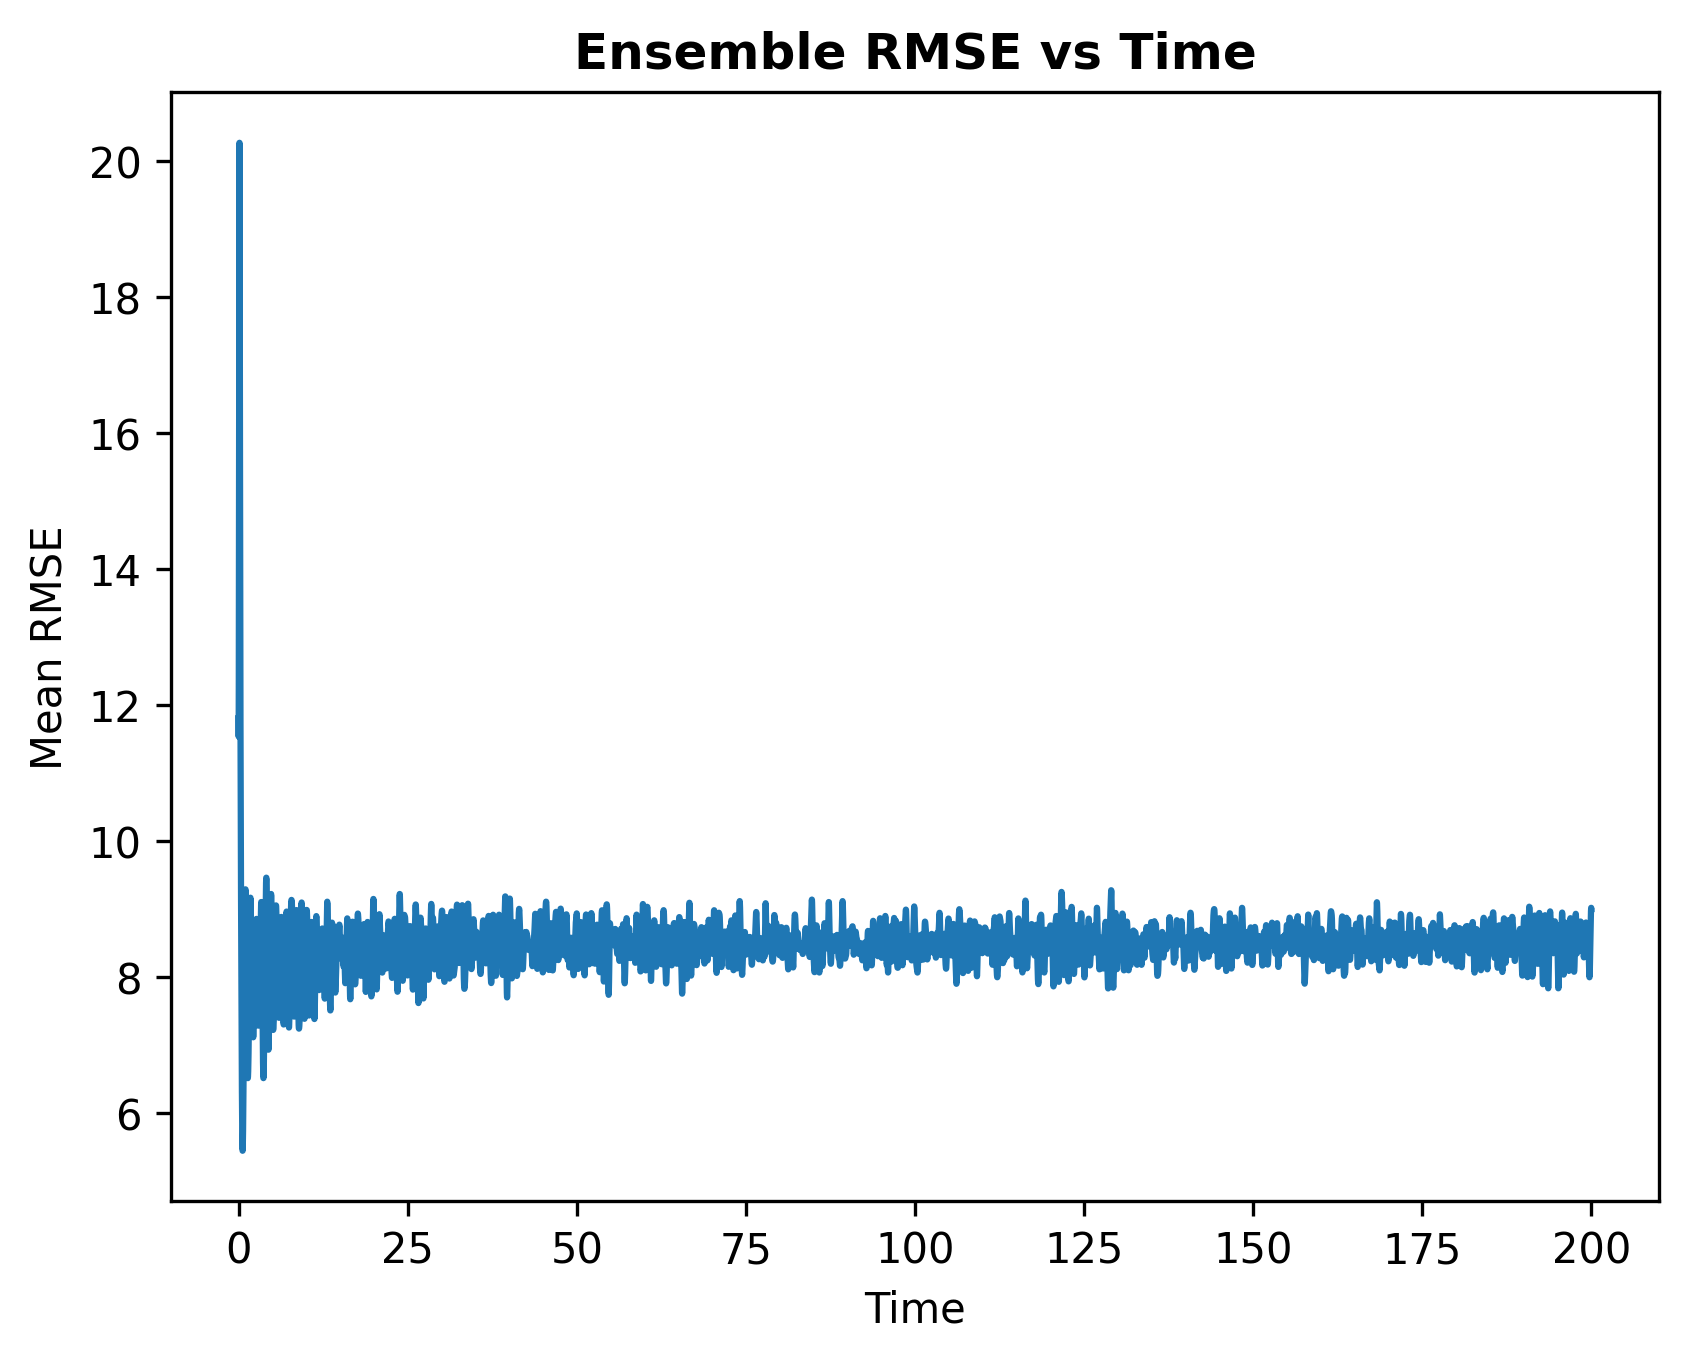

In [5]:
plt.figure(dpi=300)
plt.plot(org_time, rmse_t)
plt.xlabel("Time")
plt.ylabel("Mean RMSE")
plt.title("Ensemble RMSE vs Time", fontweight="bold")
plt.show()

We can observe a drastic spike at $t \approx 0$. This is expected, because we uniformly sample the initial values from $A := \left[ -20, 20 \right]^3$ with $diam(A) = 40 \sqrt{3}$. Thus, the RMSE for the initial values will be rather large before the trajectories begin their spirals.


As the next step, we will use this enemble of Lorenz runs to estimate the Background Covariance $B$. 

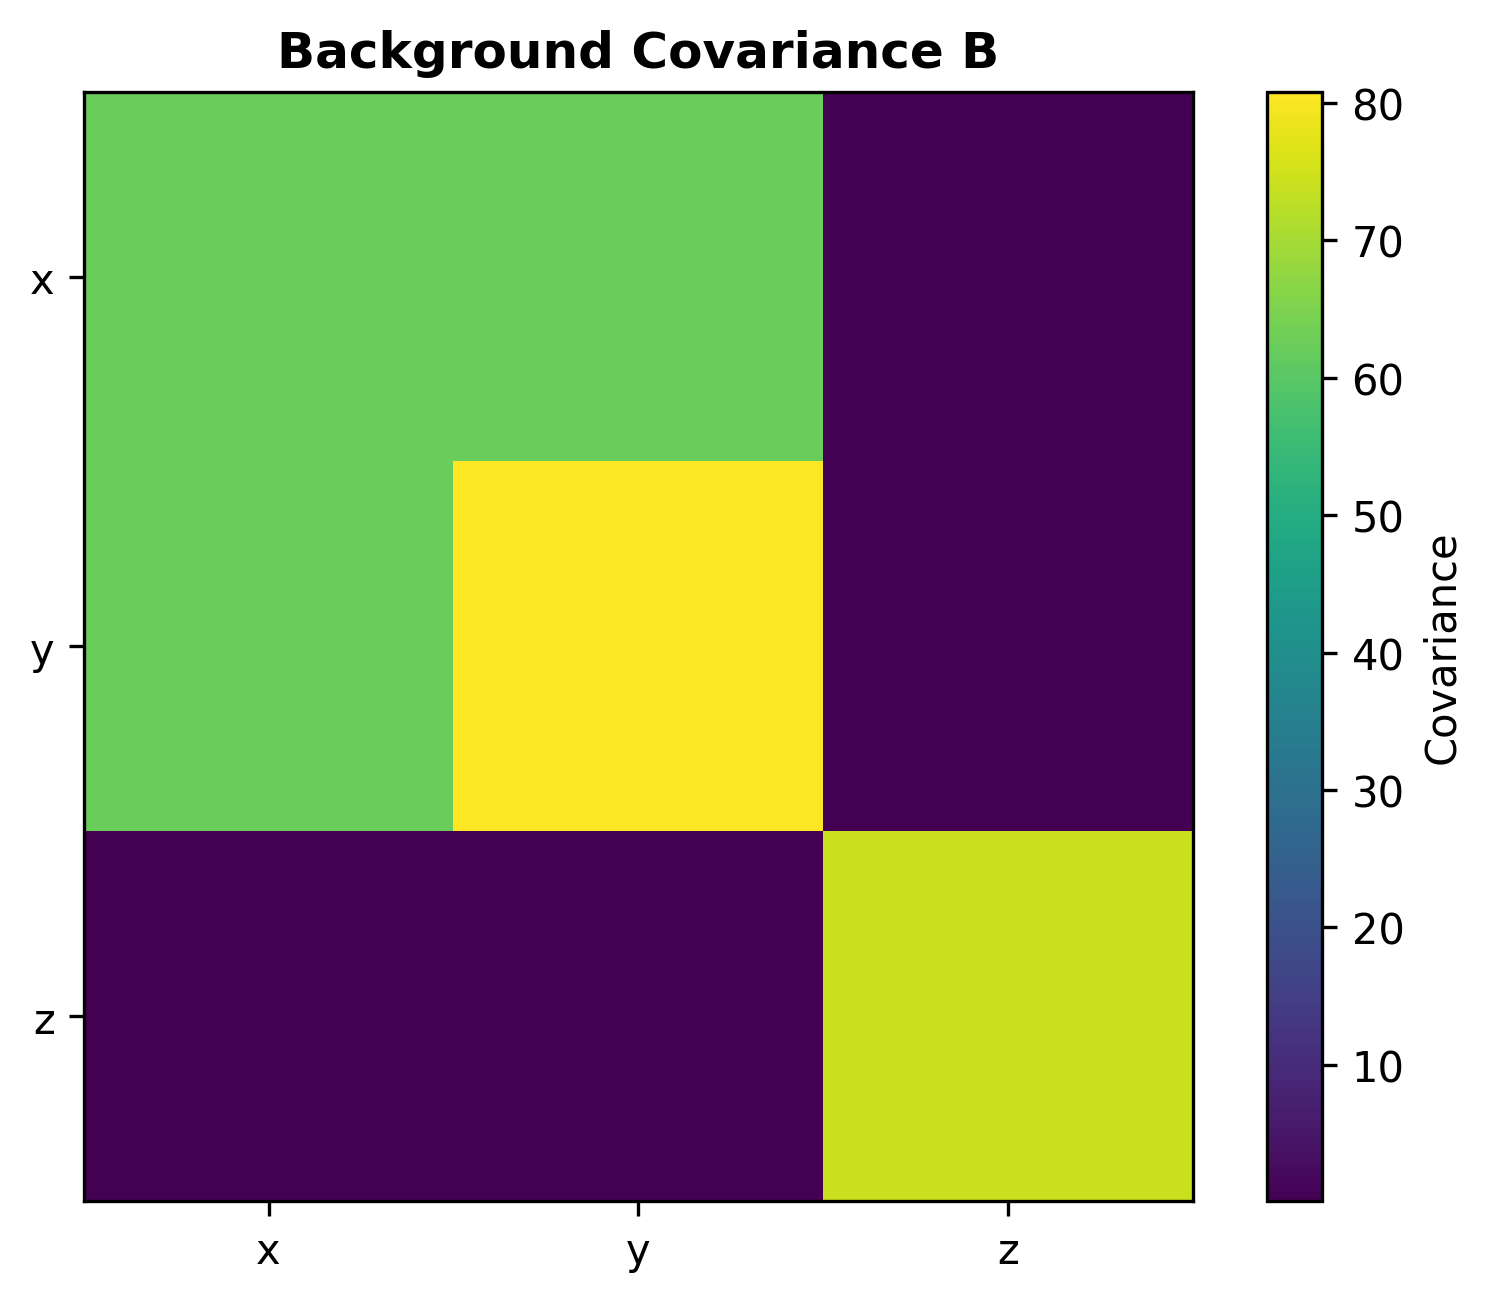

In [6]:
plt.figure(dpi=300)
plt.imshow(B, cmap="viridis", interpolation="none")
plt.colorbar(label="Covariance")
plt.title("Background Covariance B", fontweight="bold")
plt.xticks([0,1,2], ["x","y","z"])
plt.yticks([0,1,2], ["x","y","z"])
plt.show()

In [7]:
B

array([[62.36621891, 62.38177306,  0.11972096],
       [62.38177306, 80.8067083 ,  0.08861803],
       [ 0.11972096,  0.08861803, 74.33993915]])

It can also be noted that this is indeed a covariance matrix, as it is positive semi-definite.

# Twin Experiment

The next step is to implement 3DVar. We will compute the Kalman Gain $K$ and determine the "classical" increment $x_t - x_b$. These increments will later be used to train a neural net on. We store all innovations, increments and values for later use.

In [8]:
R = (obs_noise_std**2) * np.eye(3)          # observation-error covariance
R_inv = np.linalg.inv(R)
K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)  # constant Kalman gain (static B)
print("3D-Var Kalman gain K:\n", K)

def assimilate_3dvar(x0_b, obs_times_idx, y_obs):
    """Return arrays of analysis and background trajectories."""
    x_b = x0_b.copy()
    x_b_series = []
    x_a_series = []
    innovations = []
    incs = []

    for k, obs_idx in enumerate(obs_times_idx):
        steps_ahead = obs_idx - (0 if k == 0 else obs_times_idx[k-1])
        x_b = integrate(x_b, steps_ahead)[-1]

        d = y_obs[k] - H @ x_b
        x_a = x_b + K @ d

        innovations.append(d)
        incs.append(x_a - x_b)
        x_b_series.append(x_b.copy())
        x_a_series.append(x_a.copy())

        x_b = x_a

    return (np.array(x_b_series), np.array(x_a_series),
            np.array(innovations), np.array(incs))

x_b_series, x_a_series, d_series, inc_series = assimilate_3dvar(
    x0_b=np.array([-8.0, 7.0, 27.0]),    # deliberately wrong initial guess
    obs_times_idx=obs_times_idx,
    y_obs=y_obs
)

3D-Var Kalman gain K:
 [[ 9.36696481e-01  4.82721031e-02  4.38144693e-05]
 [ 4.82721031e-02  9.50966152e-01 -1.90323972e-05]
 [ 4.38144693e-05 -1.90323972e-05  9.86726780e-01]]


We will now construct the feature matrix, which consists of the $x_b$ values and the noisy observations. The target variable is the known truth minus $x_b$. We make an $80 / 20$ train-test split and train a neural network with three hidden layers, and use Adam as the optimizer.

In [9]:
train_frac = 0.8
n_cycles   = len(obs_times_idx)
n_train    = int(train_frac * n_cycles)

X_feat = np.hstack([
    x_b_series,    
    y_obs     
])                    

truth_at_obs = truth[obs_times_idx]    
y_target = truth_at_obs - x_b_series  
# y_target = inc_series.copy()  

X_train = torch.tensor(X_feat[:n_train], dtype=torch.float32)
y_train = torch.tensor(y_target[:n_train], dtype=torch.float32)
X_val   = torch.tensor(X_feat[n_train:], dtype=torch.float32)
y_val   = torch.tensor(y_target[n_train:], dtype=torch.float32)

mlp = nn.Sequential(
    nn.Linear(6, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 32), nn.ReLU(),
    nn.Linear(32, 16), nn.ReLU(),
    nn.Linear(16, 3)
)

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

best_val = float("inf")
patience = 50
wait     = 0

for epoch in range(1000):
    mlp.train()
    optimizer.zero_grad()
    loss = loss_fn(mlp(X_train), y_train)
    loss.backward(); optimizer.step()

    mlp.eval()
    with torch.no_grad():
        val_loss = loss_fn(mlp(X_val), y_val).item()

    if val_loss < best_val - 1e-5:
        best_val = val_loss
        wait = 0
    else:
        wait += 1
        if wait > patience:
            print(f"Early-stopping at epoch {epoch}")
            break

print("Best validation MSE:", best_val)
mlp.eval()

Best validation MSE: 0.3601377308368683


Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=3, bias=True)
)

We observe an RMSE of $0.36$. It is now left to combine the Neural Network estimates with 3DVar.

In [10]:
d_mat = np.array(d_series)      
d_mean = d_mat.mean(axis=0)
print("Mean innovation μ_d:", d_mean)

S_hat = (d_mat - d_mean).T @ (d_mat - d_mean) / (d_mat.shape[0] - 1)
S_theo = H @ B @ H.T + R
print("\nSample innovation cov Ŝ:\n", S_hat)
print("\nTheoretical S = HBH^T + R:\n", S_theo)

fro_norm = np.linalg.norm(S_hat - S_theo, ord="fro")
print("\nFrobenius norm |Ŝ - S|_F =", fro_norm)

Mean innovation μ_d: [-0.00059052  0.00278293 -0.00093132]

Sample innovation cov Ŝ:
 [[ 1.67927639  0.2575634  -0.05648948]
 [ 0.2575634   1.9259891   0.02712371]
 [-0.05648948  0.02712371  1.95576741]]

Theoretical S = HBH^T + R:
 [[63.36621891 62.38177306  0.11972096]
 [62.38177306 81.8067083   0.08861803]
 [ 0.11972096  0.08861803 75.33993915]]

Frobenius norm |Ŝ - S|_F = 152.6117602064715


In [11]:
x_b  = np.array([-8.0, 7.0, 27.0])  # same bad start
rmse_ml = []
rmse_3d = []

for k, obs_idx in enumerate(obs_times_idx):
    steps_ahead = obs_idx - (0 if k == 0 else obs_times_idx[k-1])
    x_b = integrate(x_b, steps_ahead)[-1]

    d = y_obs[k] - H @ x_b
    δ_3d = K @ d

    feat = torch.tensor(np.hstack([x_b, y_obs[k]]), dtype=torch.float32)
    δ_ml = mlp(feat).detach().numpy()

    x_a_3d = x_b + δ_3d
    x_a_ml = x_b + δ_ml

    err = np.linalg.norm(x_a_3d - truth[obs_idx])
    rmse_3d.append(err)

    err = np.linalg.norm(x_a_ml - truth[obs_idx])
    rmse_ml.append(err)
    
    x_b = x_a_3d

print("ML mean L2 error:", np.mean(rmse_ml))
print("3D mean L2 error:", np.mean(rmse_3d))

ML mean L2 error: 0.9297423015680417
3D mean L2 error: 1.5289940864996454


We observe that the ML mean L2 error is in general better than the 3DVar mean L2 error.

In [12]:
def run_cycle(x0: np.ndarray,
              gain: Callable[[np.ndarray, np.ndarray], np.ndarray],
              label: str) -> Dict[str, np.ndarray]:
    x_b  = x0.copy()
    b_hist, a_hist, rmse_hist = [], [], []

    for k, idx in enumerate(obs_times_idx):
        steps = idx - (0 if k == 0 else obs_times_idx[k-1])
        x_b   = integrate(x_b, steps)[-1]

        x_a   = gain(x_b, y_obs[k])

        b_hist.append(x_b)
        a_hist.append(x_a)
        rmse_hist.append(np.linalg.norm(x_a - truth[idx]))

        x_b = x_a

    return {"label": label,
            "x_b":  np.vstack(b_hist),
            "x_a":  np.vstack(a_hist),
            "rmse": np.array(rmse_hist)}


def classic_gain(x_b, y_k):
    d = y_k - H @ x_b    
    return x_b + K @ d          


def ml_gain(x_b, y_k):
    feat  = torch.tensor(np.hstack([x_b, y_k]), dtype=torch.float32)
    δ_ml  = mlp(feat).detach().numpy()        # neural-net increment
    return x_b + δ_ml                         # x_a = x_b + δ̂_ml

        Method  Mean L2 error  Median L2 error  Min (best)
        3D-Var         1.5290           1.4732      0.0187
Predicted-Incr         0.7712           0.7231      0.0031


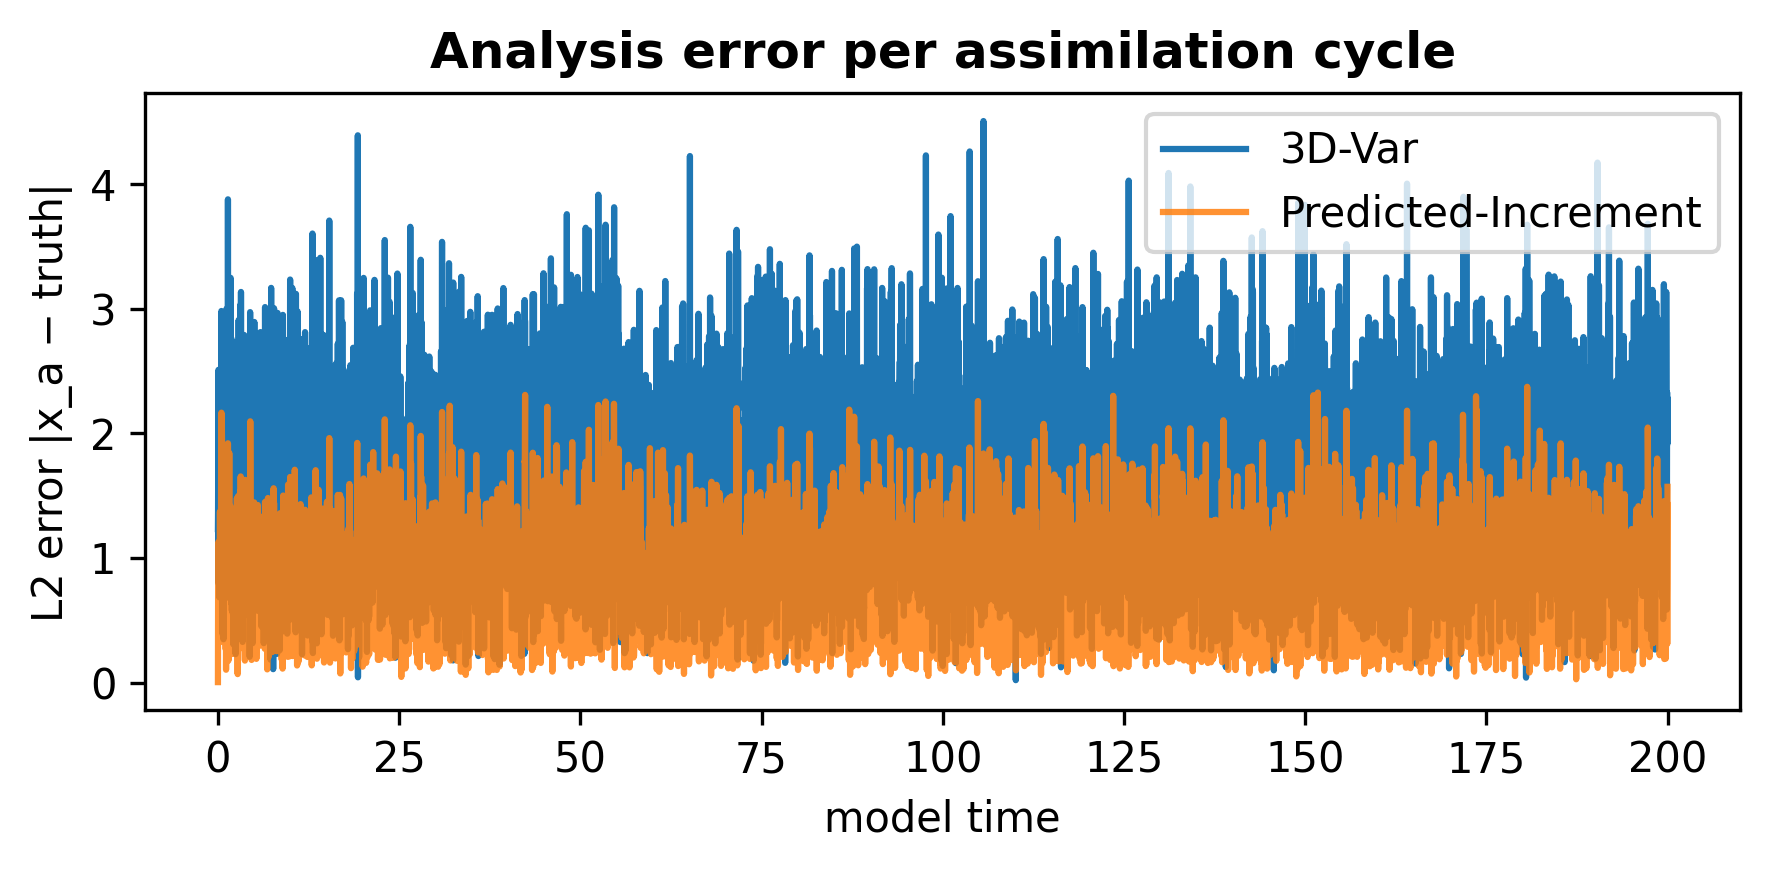

In [13]:
x0_bad = np.array([-8.0, 7.0, 27.0])      # same poor starting guess

standard  = run_cycle(x0_bad, classic_gain, label="3D-Var")
pred_inc  = run_cycle(x0_bad, ml_gain    , label="Predicted-Incr")

summary = pd.DataFrame({
    "Method":        [standard["label"], pred_inc["label"]],
    "Mean L2 error":     [standard["rmse"].mean(), pred_inc["rmse"].mean()],
    "Median L2 error":   [np.median(standard["rmse"]), np.median(pred_inc["rmse"])],
    "Min (best)":    [standard["rmse"].min(), pred_inc["rmse"].min()]
})
print(summary.to_string(index=False, float_format="%.4f"))

t = obs_times_idx * dt
plt.figure(figsize=(6,3), dpi=300)
plt.plot(t, standard["rmse"], label="3D-Var")
plt.plot(t, pred_inc["rmse"], label="Predicted-Increment", alpha=0.85)
plt.xlabel("model time"); plt.ylabel("L2 error |x_a − truth|")
plt.title("Analysis error per assimilation cycle", fontweight="bold")
plt.legend(); plt.tight_layout()
plt.savefig("ana_error.pdf")
plt.show()

The predicted increments have much less error and variance (less number of spikes). The neural network approach outperforms 3D-Var. This shows the effectiveness of machine learning in improving data assimilation for chaotic systems.

In [14]:
def run_experiment(R_scalar):
    R = (R_scalar**2) * np.eye(3)
    y_obs = truth[obs_times_idx] + np.random.normal(0, R_scalar, size=(len(obs_times_idx), 3))
    K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
    x_b = np.array([-8.0, 7.0, 27.0])
    rmse = []
    for k, obs_idx in enumerate(obs_times_idx):
        steps_ahead = obs_idx - (0 if k==0 else obs_times_idx[k-1])
        x_b = integrate(x_b, steps_ahead)[-1]

        feat = torch.tensor(np.hstack([x_b, y_obs[k]]), dtype=torch.float32)
        δ_ml = mlp(feat).detach().numpy()
        x_a = x_b + δ_ml
        rmse.append(np.linalg.norm(x_a - truth[obs_idx]))
        x_b = x_a
    return np.mean(rmse)


def monte_carlo_run_experiment(R_scalar, num_trials=100):
    rmse_list = []
    for _ in range(num_trials):
        rmse = run_experiment(R_scalar)
        rmse_list.append(rmse)
    return np.mean(rmse_list), np.std(rmse_list)

for σ_r in [1.0,  np.sqrt(2.0),  np.sqrt(5.0)]:
    mean_rmse, std_rmse = monte_carlo_run_experiment(σ_r, num_trials=100)
    print(f"R variance = {σ_r**2:.1f}  → mean L2 error = {mean_rmse:.3f} ± {std_rmse:.3f}")

R variance = 1.0  → mean L2 error = 0.790 ± 0.005
R variance = 2.0  → mean L2 error = 1.093 ± 0.008
R variance = 5.0  → mean L2 error = 1.711 ± 0.012


Monte Carlo experiments are conducted with R variances of 1, 2, and 5 to assess sensitivity. This helps evaluate how well the neural network generalizes across varying observational uncertainties. The results show that ML performance degrades as observation noise increases. RMSE grows from 0.791 (R=1) to 1.709 (R=5), with very little increment in standard deviations indicating steady performance.

Method      3D-Var  Hybrid  PredInc
R variance                         
1           1.5296  1.1008   0.7864
2           2.0928  1.5307   1.0926
5           3.0787  2.3129   1.7050


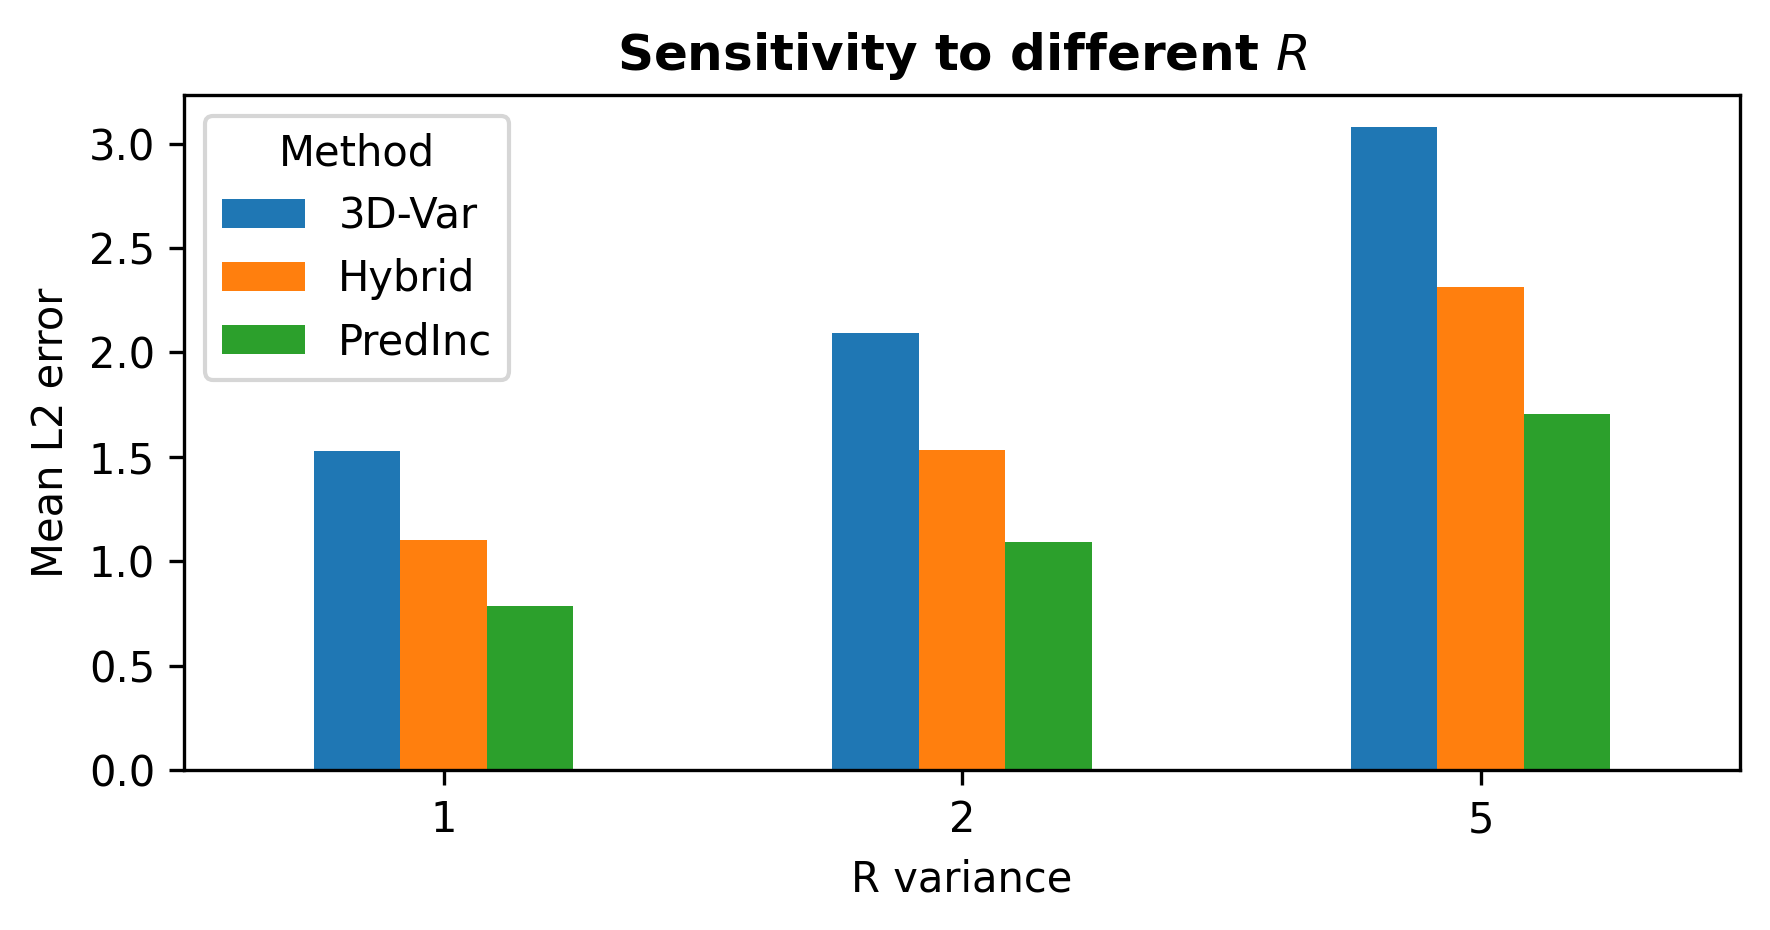

In [15]:
sigma_list = [1.0, np.sqrt(2.0), np.sqrt(5.0)]   # std ⇒ variances = 1, 2, 5
w_blend    = 0.5                                 # same hybrid weight as before
x0_bad     = np.array([-8.0, 7.0, 27.0])         # identical poor start

records = []

for sigma_r in sigma_list:
    R = (sigma_r**2) * np.eye(3)
    y_obs = truth[obs_times_idx] + np.random.normal(0, sigma_r, size=(len(obs_times_idx), 3))
    
    K_var = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)

    def classic_gain_var(x_b, y_k, K=K_var):
        d = y_k - H @ x_b
        return x_b + K @ d

    def hybrid_gain_var(x_b, y_k, K=K_var):
        d    = y_k - H @ x_b
        δ_3d = K @ d
        δ_ml = mlp(torch.tensor(np.hstack([x_b, y_k]), dtype=torch.float32)).detach().numpy()
        return x_b + w_blend * δ_3d + (1 - w_blend) * δ_ml

    res_std   = run_cycle(x0_bad, classic_gain_var, label="3D-Var")
    res_ml    = run_cycle(x0_bad, ml_gain,          label="PredInc")       #  δ̂_ml only
    res_hyb   = run_cycle(x0_bad, hybrid_gain_var,  label="Hybrid")

    for res in (res_std, res_ml, res_hyb):
        records.append({
            "R variance": round(sigma_r**2),
            "Method":     res["label"],
            "Mean RMSE":  res["rmse"].mean()
        })

df = pd.DataFrame(records)
print(df.pivot(index="R variance", columns="Method", values="Mean RMSE").round(4))

ax = df.pivot(index="R variance", columns="Method", values="Mean RMSE").plot(
        kind="bar", figsize=(6,3.2), rot=0)
ax.set_ylabel("Mean L2 error")
ax.set_title("Sensitivity to different $R$", fontweight="bold")
plt.gcf().set_dpi(300)
plt.tight_layout(); 
plt.savefig("sens.pdf")
plt.show()

The plot implies PredInc performs best across all noise levels, followed by Hybrid, then 3D-Var. As noise increases, all methods get worse, but PredInc stays the most accurate. The hybrid approach gives results between the pure methods.

In [16]:
K # constant kalman gain

array([[ 9.36696481e-01,  4.82721031e-02,  4.38144693e-05],
       [ 4.82721031e-02,  9.50966152e-01, -1.90323972e-05],
       [ 4.38144693e-05, -1.90323972e-05,  9.86726780e-01]])

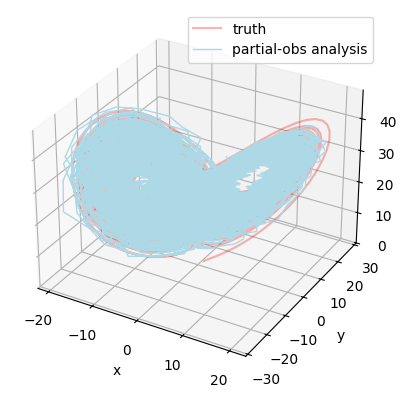

In [17]:
H_partial = np.array([[1.0, 0.0, 0.0]])   # 1×3
R_scalar  = obs_noise_std**2
R_partial = np.array([[R_scalar]])
y_obs = truth[obs_times_idx] + np.random.normal(0, R_scalar, size=(len(obs_times_idx), 3))

K_partial = B @ H_partial.T @ np.linalg.inv(H_partial @ B @ H_partial.T + R_partial)

x_b = np.array([-8.0, 7.0, 27.0])
x_a_store = []

for k, obs_idx in enumerate(obs_times_idx):
    steps_ahead = obs_idx - (0 if k==0 else obs_times_idx[k-1])
    x_b = integrate(x_b, steps_ahead)[-1]
    d   = y_obs[k, :1] - H_partial @ x_b       
    x_a = x_b + (K_partial @ d).flatten()
    x_a_store.append(x_a)
    x_b = x_a

x_a_store = np.array(x_a_store)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(projection='3d')
ax.plot(*truth.T, color='red', alpha=0.3, label='truth')
ax.plot(*x_a_store.T, color='lightblue', lw=1, label='partial-obs analysis')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.legend(); plt.tight_layout()
plt.show()

This test uses only x-coordinate observations to track the full 3D system. The light blue line shows the analysis stays close to the true path (red).  With partial observations, 3D-Var can somewhat estimate the full state.

In [18]:
truth_trace = go.Scatter3d(
    x=truth[:, 0],
    y=truth[:, 1],
    z=truth[:, 2],
    mode='lines',
    line=dict(
        dash='dash',
        width=4
    ),
    opacity=0.8,
    name='Truth trajectory'
)

# 2 & 3) Analysis path with thicker solid line + markers
analysis_trace = go.Scatter3d(
    x=x_a_store[:, 0],
    y=x_a_store[:, 1],
    z=x_a_store[:, 2],
    mode='lines+markers',
    line=dict(width=2),
    marker=dict(
        size=4,    # adjust to taste (Matplotlib’s s=30 ≈ size=4–6 here)
        opacity=0.5,
        symbol='circle'
    ),
    name='Partial-obs analysis'
)

# Assemble figure
fig = go.Figure(data=[truth_trace, analysis_trace])

# 4) Labels, grid and title
fig.update_layout(
    title='3D Trajectory: Truth vs Partial-Obs Analysis',
    width=800,
    height=600,
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z',
        # grid is on by default; you can tweak gridcolor/lightness here if you like
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# 5) Viewing angle (convert Matplotlib’s elev=25°, azim=60° into a camera eye position)
fig.update_layout(
    scene_camera=dict(
        eye=dict(x=1.25, y=1.25, z=0.8)
    )
)

# 6) Legend is on by default in Plotly; show it
fig.update_layout(showlegend=True)

# Render it
fig.show()